In [55]:
# ============================================================
#  Imports + settings
# ============================================================


import os
import re
import sys
import warnings
import importlib
from pathlib import Path


import numpy as np
import pandas as pd


import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA


from scipy.stats import ttest_ind, mannwhitneyu
from matplotlib.ticker import LogLocator


import plsda_module
from plsda_module import PLSDA


warnings.filterwarnings("ignore")
np.random.seed(42)


# Optional plotting defaults (edit to taste)
mpl.rcParams["pdf.fonttype"] = 42
mpl.rcParams["ps.fonttype"] = 42

In [56]:
# ============================================================
#  Paths + I/O filenames
# ============================================================

IN_FILE = "2025_Melanoma_EpiGene_Dependency_GaussianClasses.csv"


OUT_SCORES_FILE = "manuscript_out/PLSDA_LV1_LV2_scores.csv"
OUT_LOADINGS_FILE = "manuscript_out/LV1_loadings_final.csv"
OUT_VIP_FILE = "manuscript_out/PLSDA_mean_signed_vip_scores.csv"

In [57]:
# ============================================================
#  Load data + minimal cleanup
# ============================================================


data = pd.read_csv(BASE_DIR / IN_FILE)


# Drop identifiers you do NOT want as model features
DROP_COLS = ["CellLine"] # keep GaussianClass for labels; we will drop it from X later
data = data.drop(columns=[c for c in DROP_COLS if c in data.columns], errors="ignore")


print("Loaded data shape:", data.shape)
print("Columns:", list(data.columns)[:10], "...")

Loaded data shape: (51, 740)
Columns: ['A1CF', 'ACTB', 'ACTL6A', 'ACTL6B', 'ACTR3B', 'ACTR5', 'ACTR6', 'ACTR8', 'ADNP', 'AEBP2'] ...


In [58]:
# ============================================================
#  Create M/U labels + binary interest_class
# ============================================================


data2 = data.copy()


# Map GaussianClass -> M/U
mu_map = {
"Melanocytic-like": "M",
"Undifferentiated/NC-like": "U",
}
data2["MU"] = data2["GaussianClass"].map(mu_map)


# Keep only rows that mapped cleanly
data2 = data2.dropna(subset=["MU"]).copy()


print("\nMU counts:\n", data2["MU"].value_counts())


# Define which state(s) are the "interest" class (example: M)
INTEREST_STATES = ["M"]


# Binary label
data2["interest_class"] = data2["MU"].isin(INTEREST_STATES).astype(int)


print("\ninterest_class counts:\n", data2["interest_class"].value_counts())


MU counts:
 MU
M    34
U    17
Name: count, dtype: int64

interest_class counts:
 interest_class
1    34
0    17
Name: count, dtype: int64


In [59]:
# ============================================================
#  Build X (numeric features only) and y (labels)
# ============================================================


# y = label
y = data2["interest_class"].copy()


# X = remove label + metadata columns, then keep numeric only
X = data2.drop(columns=["interest_class", "GaussianClass", "MU"], errors="ignore")
X = X.select_dtypes(include="number")


print("\nX shape:", X.shape)
print("y counts:\n", y.value_counts())


if X.shape[1] == 0:
    raise ValueError("X has 0 numeric features after filtering. Check which columns are numeric.")




X shape: (51, 739)
y counts:
 interest_class
1    34
0    17
Name: count, dtype: int64


In [60]:
# ============================================================
#  Reload your module during development
# ============================================================


# Only useful while you are actively editing plsda_module.py
importlib.reload(plsda_module)
from plsda_module import PLSDA

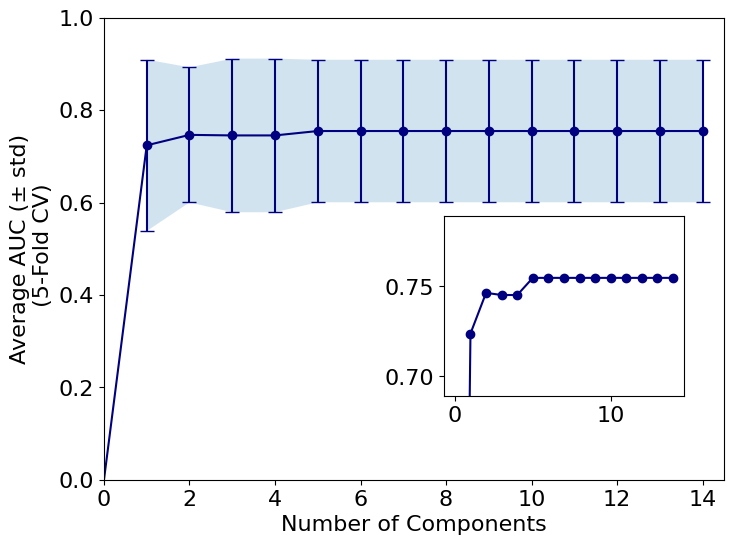

Maximum AUC at components: 5
Diminishing returns at components: 2
Maximum mean AUC: 0.755 ± 0.154
AUC at diminishing returns: 0.746 ± 0.146
Recommended number of components: 2

Optimal number of components (CV): 2
Component 1:
Cumulative Y variance: 81.18%
Incremental Y variance: 81.18%
Component 2:
Cumulative Y variance: 96.86%
Incremental Y variance: 15.68%


In [61]:
# ============================================================
#  Run PLS-DA (component selection + fit/transform)
# ============================================================


plsda = PLSDA(
n_components=None,
cv_folds=5,
one_hot_encode=False,
downsample_ratio=None
)


# Choose optimal components (you can save the plot if you want)
optimal_components, mean_scores = plsda.find_optimal_components(
X, y,
max_components=14,
save_plot=False
)
print(f"\nOptimal number of components (CV): {optimal_components}")


# Set the number of components you actually want to use (you chose 2)
plsda.n_components = 2


X_pls, x_var, y_var, y_encoded, X_downsampled, y_balanced = plsda.fit_transform(X, y)

In [62]:
# ============================================================
#  Save LV1/LV2 scores (one time, with best available sample IDs)
# ============================================================


# Choose a sample label column:
# - If X_downsampled is a DataFrame, use its index (best)
# - Otherwise, fall back to original row index
if isinstance(X_downsampled, pd.DataFrame):
    sample_ids = X_downsampled.index.astype(str)
else:
    sample_ids = data2.index.astype(str)


scores_df = pd.DataFrame({
"Sample": sample_ids,
"LV1": X_pls[:, 0],
"LV2": X_pls[:, 1],
"Class": y_balanced
})


scores_df.to_csv(OUT_SCORES_FILE, index=False)
print(f"Saved LV1/LV2 scores to: {OUT_SCORES_FILE}")

Saved LV1/LV2 scores to: manuscript_out/PLSDA_LV1_LV2_scores.csv


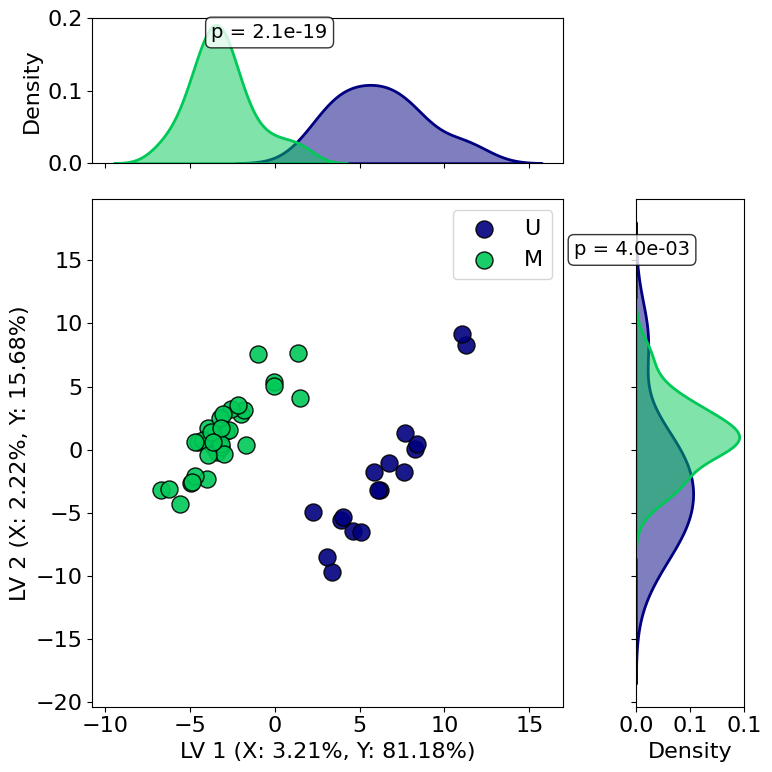

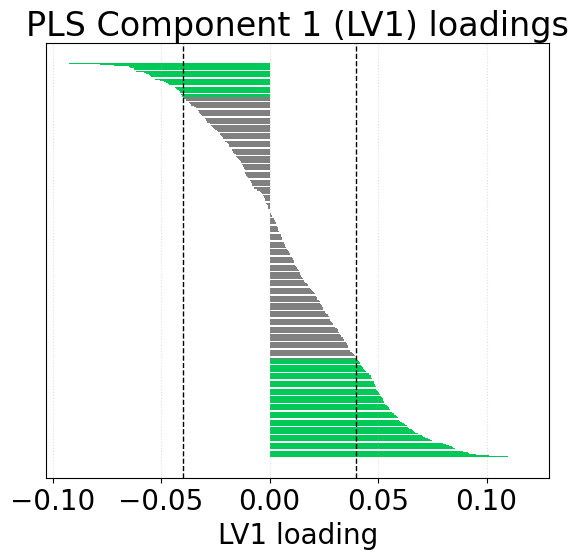

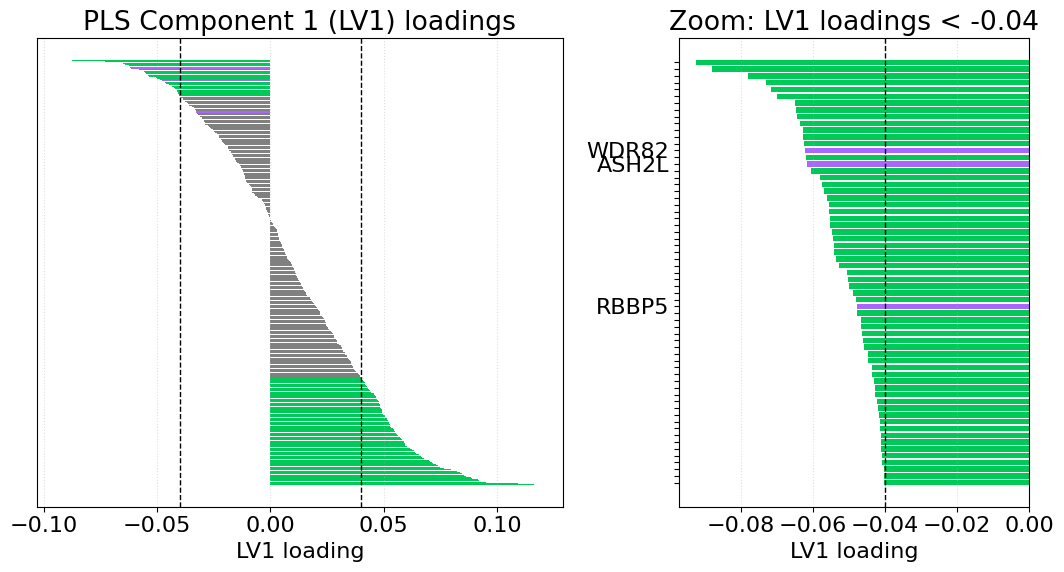

Saved LV1 loadings to: manuscript_out/LV1_loadings_final.csv


In [63]:
# ============================================================
#  Score plot + LV1 loadings outputs
# ============================================================


# Define what the classes mean in the plot
# (Set these explicitly so they’re not undefined)
type_1 = "M" # interest class label
type_2 = "U" # other class label
class_descriptions = {0: type_2, 1: type_1}


plot_scores = plsda.plot_scores_with_density(
X_pls, x_var, y_var, y_encoded,
lv1=0, lv2=1,
class_descriptions=class_descriptions,
alpha_values=[0.9, 0.9],
colors=["navy", "#00C957"],
line_colors=["k", "k"],
save_plot=True,
size=[150, 150]
)


loadings_plt = plsda.plot_lv1_loadings_bar()
loadings_zoom_plt = plsda.plot_lv1_loadings_bar_with_zoom(feature_names=X.columns)


_ = plsda.save_lv1_loadings(X, str(OUT_LOADINGS_FILE))
print(f"Saved LV1 loadings to: {OUT_LOADINGS_FILE}")

In [64]:
# ============================================================
#  Repeated VIP summary + save
# ============================================================


mean_vip, std_vip, mean_signed_vip, std_signed_vip, feature_names = plsda.compute_repeated_vip(
X, y,
feature_names=X.columns,
n_repeats=50
)


vip_df = pd.DataFrame({
"feature_name": feature_names,
"mean_vip": mean_vip,
"std_vip": std_vip,
"mean_signed_vip": mean_signed_vip,
"std_signed_vip": std_signed_vip
})


vip_df.to_csv(OUT_VIP_FILE, index=False)
print(f"Saved VIP summary to: {OUT_VIP_FILE}")

Saved VIP summary to: manuscript_out/PLSDA_mean_signed_vip_scores.csv
